# A hybrid Intrusion Model Using LSTM and GRU, PSO for feature selection, and SMOTE for data balancing 

### The dataset for this analysis is the NSL-KDD-99 dataset

In [33]:
!pip install pyswarms

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

# compressing the ML future warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# data balancing techniques
from imblearn.over_sampling import SMOTE
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single import GlobalBestPSO 

# machine learning model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# deep learning model
from tensorflow import keras
from keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Input, Reshape

In [188]:
## reading the columns names for the KDDTrain+ and KDDTest+ datasets
column_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

In [189]:
# reading the train dataset
df_train = pd.read_csv("NSL_KDD_Train.csv", header=None, names=column_names)

# reading the test dataset
df_test = pd.read_csv("NSL_KDD_Test.csv", header=None, names=column_names)

# Concatenate the two datasets
df = pd.concat([df_train, df_test], ignore_index=True)

In [190]:
print(f"The NSL-KDD-99 dataset has {df.shape[0]} records with {df.shape[1]} features")

The NSL-KDD-99 dataset has 148517 records with 42 features


In [191]:
# select few records considering the dataset is much
# df = df.sample(n=10000, random_state=42)

In [192]:
# checking the data types of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

In [193]:
# getting the statistical descriptions
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,148517.000000,1.485170e+05,1.485170e+05,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,...,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000
mean,276.779305,4.022795e+04,1.708885e+04,0.000215,0.020523,0.000202,0.189379,0.004323,0.402789,0.255062,...,183.928042,119.462661,0.534521,0.084103,0.145932,0.030584,0.256122,0.251304,0.136220,0.136397
std,2460.683131,5.409612e+06,3.703525e+06,0.014677,0.240069,0.019417,2.013160,0.072248,0.490461,22.231375,...,98.528328,111.232318,0.448061,0.194102,0.308638,0.108975,0.428500,0.429719,0.322741,0.335282
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,87.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,72.000000,0.600000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.780000e+02,5.710000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.050000,0.010000,0.600000,0.500000,0.000000,0.000000
max,57715.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,101.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [194]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

In [195]:
def plot_corr_matrix(cols):
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df[cols].corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)

    # Show the plot
    plt.show()

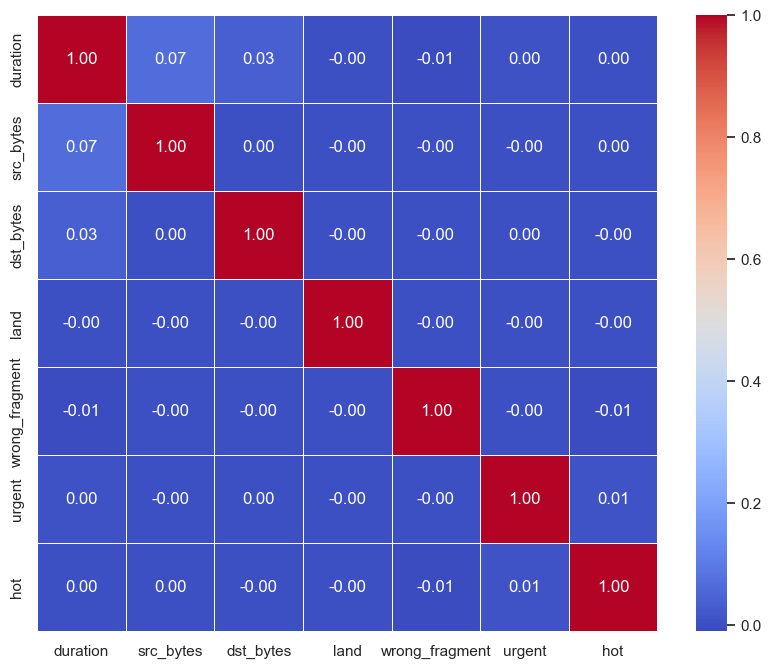

In [196]:
# checking the dataset correlations 
plot_corr_matrix(['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',\
                  'land', 'wrong_fragment', 'urgent', 'hot',])

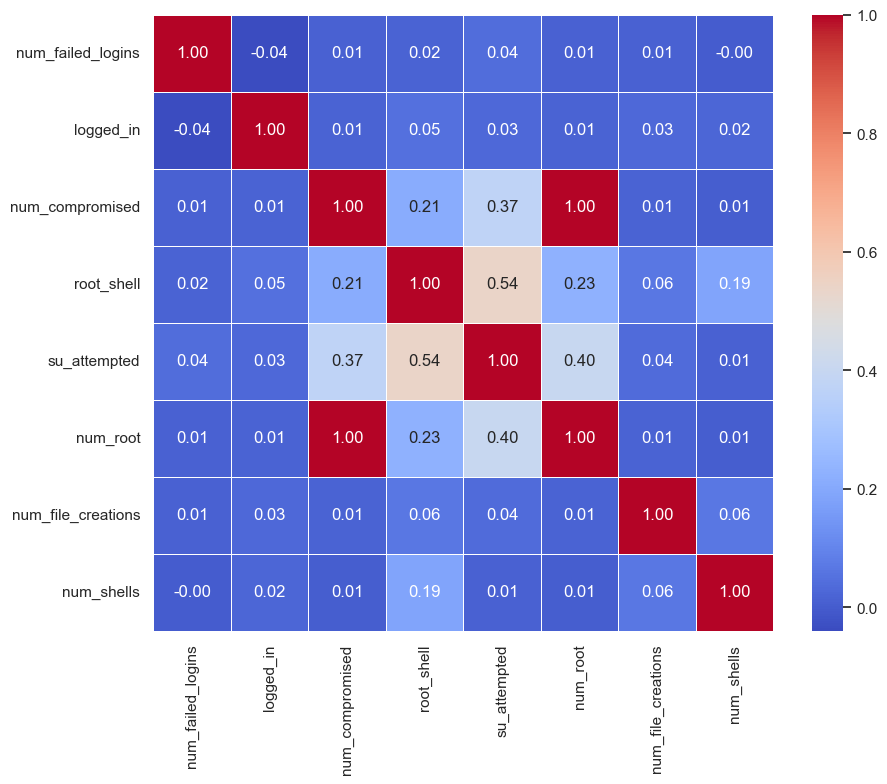

In [197]:
# checking the dataset correlations 
plot_corr_matrix(['num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',])

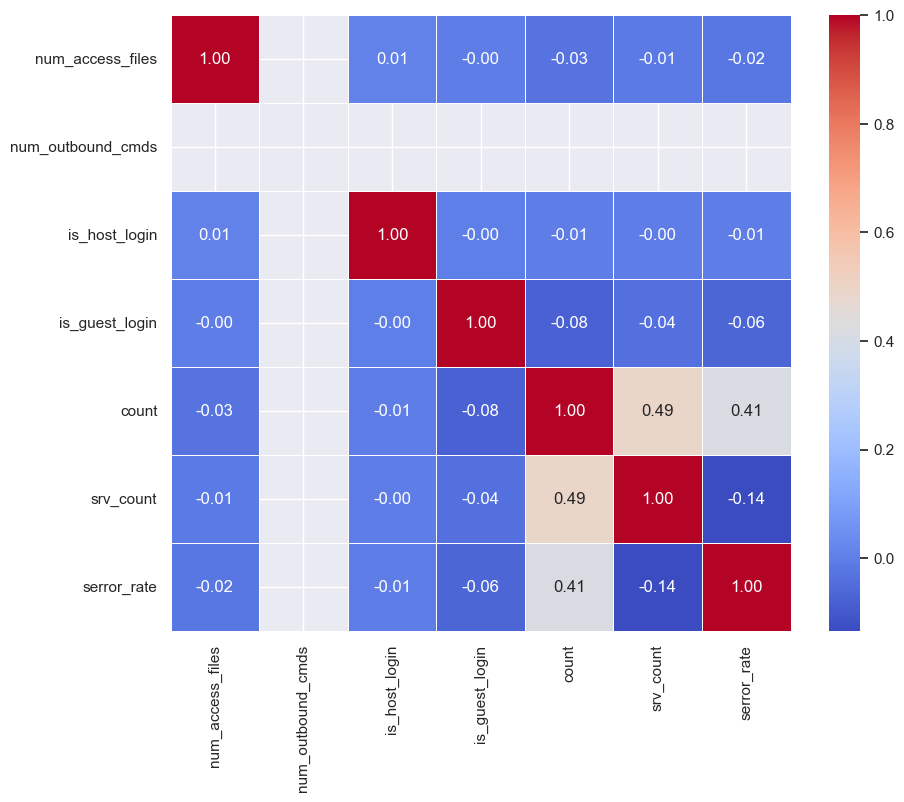

In [198]:
# checking the dataset correlations 
plot_corr_matrix(['num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',])

# Data Transformation

In [199]:
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 40 categories

Distribution of categories in service:
http        48191
private     26627
domain_u     9937
smtp         8247
ftp_data     7711
Name: service, dtype: int64


In [200]:
df['label'].value_counts()

normal             77054
neptune            45871
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
loadmodule            11
ftp_write             11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm               2


In [201]:
def plot_attributes(df, label, xlabel):
    # Plotting the distribution of classes in the 'label' column
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=label, data=df)
    plt.title('Distribution of Classes in the Label Column')
    plt.xlabel(xlabel)
    plt.ylabel('Count')

    # Rotate x-axis labels for better visibility
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    plt.show()

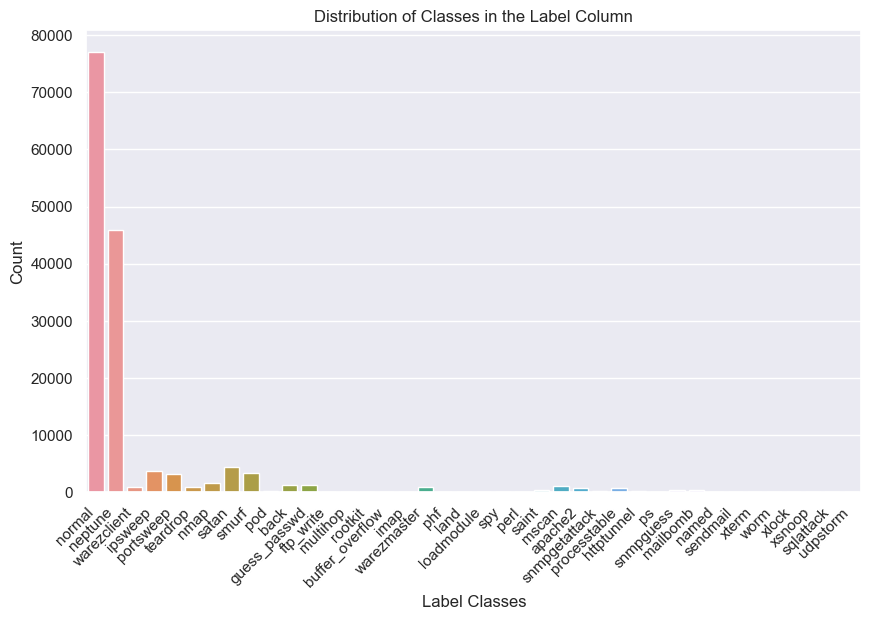

In [202]:
plot_attributes(df, "label", "Label Classes")

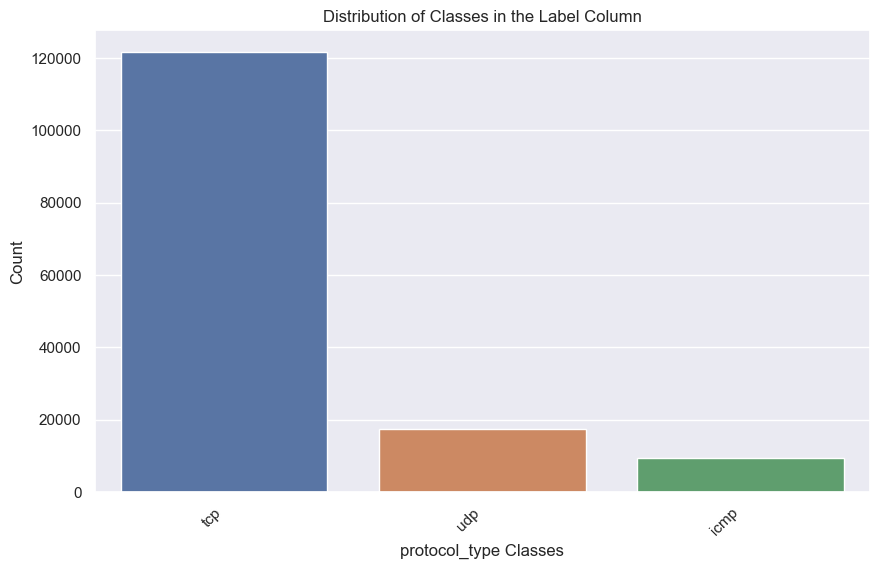

In [203]:
plot_attributes(df, "protocol_type", "protocol_type Classes")

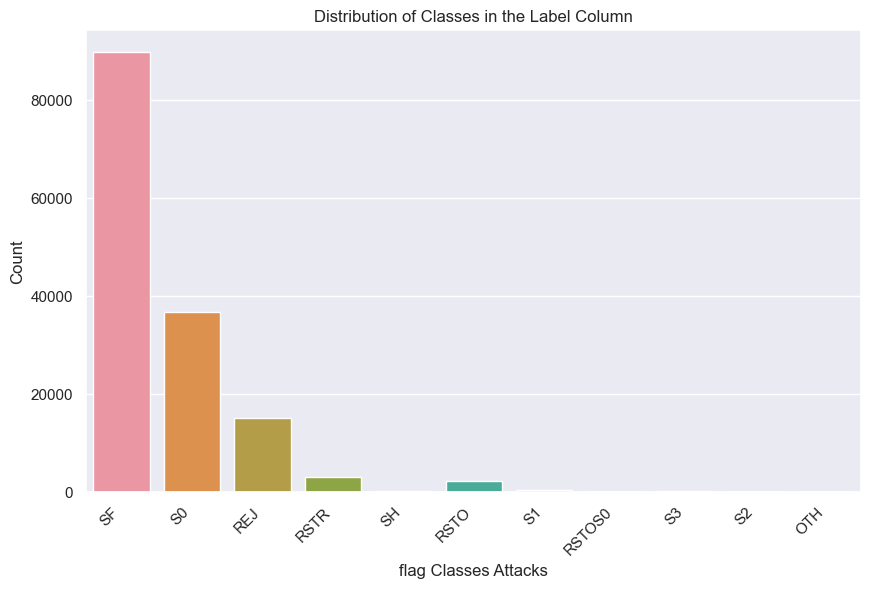

In [204]:
plot_attributes(df, "flag", "flag Classes Attacks")

In [205]:
categorical_columns=['protocol_type', 'service', 'flag']
df_categorical_values = df[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [206]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

In [207]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


In [208]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)

In [209]:
newdf = df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

print(newdf.shape)

(148517, 123)


In [210]:
newdf.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [211]:
newdf.dropna(axis=1, inplace=True)
newdf.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [212]:
labeldf = newdf['label']

# change the label column
newlabeldf = labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

In [213]:
# put the new label column back
newdf['label'] = newlabeldf

In [214]:
newdf['label'].value_counts()

0    77054
1    53387
2    14077
3     3880
4      119
Name: label, dtype: int64

In [215]:
# Convert "label" into normal=0 and attack=1 for KDDTrain+
newdf['class']= newdf['label'].apply(lambda x: 1 if x >= 1 else 0)
newdf.drop(['label'], axis=1)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,794,333,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
148513,0,317,938,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
148514,0,54540,8314,0,0,0,2,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
148515,0,42,42,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [216]:
newdf.groupby('class').count()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
class,,,,,,,,,,,,,,,,,,,,,
0,77054,77054,77054,77054,77054,77054,77054,77054,77054,77054,...,77054,77054,77054,77054,77054,77054,77054,77054,77054,77054
1,71463,71463,71463,71463,71463,71463,71463,71463,71463,71463,...,71463,71463,71463,71463,71463,71463,71463,71463,71463,71463


In [217]:
newdf.isna().sum()

duration          0
src_bytes         0
dst_bytes         0
land              0
wrong_fragment    0
                 ..
flag_S2           0
flag_S3           0
flag_SF           0
flag_SH           0
class             0
Length: 124, dtype: int64

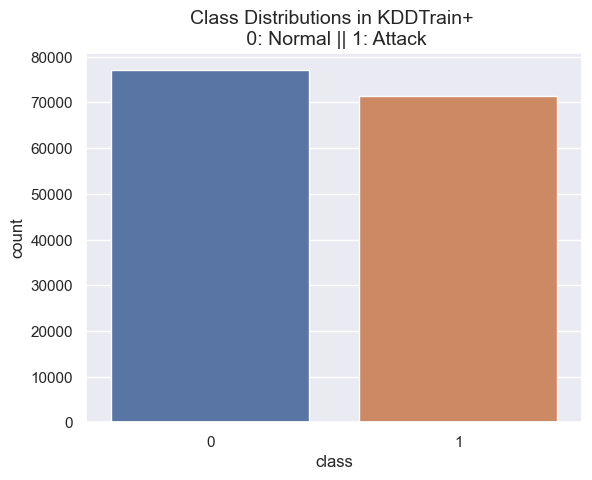

In [218]:
sns.countplot(x="class", data=newdf)
plt.title('Class Distributions in KDDTrain+ \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

In [219]:
# step1: apply the logarithmic scaling method for scaling to obtain the ranges of `duration[0,4.77]', `src_bytes[0,9.11]' and `dst_bytes[0,9.11]
newdf['log_duration'] = np.log2(newdf['duration'])
newdf['log_src_bytes'] = np.log2(newdf['src_bytes'])
newdf['log_dst_bytes'] = np.log2(newdf['dst_bytes'])
newdf=newdf.drop(['log_dst_bytes','log_src_bytes','log_duration'], axis=1)
newdf.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [220]:
X = newdf.drop('class', 1)
Y = newdf["class"]

In [221]:
X_cols = X.columns

In [222]:
scale= StandardScaler().fit(X)
X = scale.transform(X)

all_X = pd.DataFrame(X, columns=X_cols)

# SMOTE Data-Balancing

In [223]:
# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Fit and transform the training data
X_resampled, y_resampled = smote.fit_resample(X, Y)

# Particle Swarm Optimization

In [224]:
# Define the objective function
def objective_function(features):
    # Convert binary indices to integer indices
    selected_features = np.where(features == 1)[0]

    # Train a model using only the selected features
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train[:, selected_features], y_train)
    
    # Make predictions on the validation set
    predictions = clf.predict(X_val[:, selected_features])
    accuracy = accuracy_score(y_val, predictions)
    
    # Maximize accuracy, so return the negative value
    return -accuracy

# Particle class
class Particle:
    def __init__(self, num_features):
        self.position = np.random.choice([0, 1], size=num_features)
        self.velocity = np.random.uniform(0, 1, size=num_features)
        self.best_position = np.copy(self.position)
        self.best_fitness = float('-inf')

# PSO function for feature selection
def particle_swarm_optimization(num_particles, num_iterations, num_features):
    particles = [Particle(num_features) for _ in range(num_particles)]

    global_best_position = None
    global_best_fitness = float('-inf')

    inertia_weight = 0.5
    cognitive_coeff = 1.5
    social_coeff = 2.0

    for iteration in range(num_iterations):
#         print(f"iteration {iteration}")
        for particle in particles:
            fitness = objective_function(particle.position)
#             print(f"iteration {iteration} objective run")

            if fitness > particle.best_fitness:
                particle.best_fitness = fitness
                particle.best_position = np.copy(particle.position)

            if fitness > global_best_fitness:
                global_best_fitness = fitness
                global_best_position = np.copy(particle.position)

        for particle in particles:
            particle.velocity = update_velocity(particle, global_best_position, inertia_weight, cognitive_coeff, social_coeff)
            particle.position = np.round(1 / (1 + np.exp(-particle.velocity)))

    return global_best_position

# Update velocity function
def update_velocity(particle, global_best_position, inertia_weight, cognitive_coeff, social_coeff):
    inertia_term = inertia_weight * particle.velocity
    cognitive_term = cognitive_coeff * np.random.rand() * (particle.best_position - particle.position)
    social_term = social_coeff * np.random.rand() * (global_best_position - particle.position)

    new_velocity = inertia_term + cognitive_term + social_term
    return new_velocity


# Assuming X and y are your feature matrix and labels
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

num_particles = 10
num_iterations = 50
num_features = X_train.shape[1]

selected_features = particle_swarm_optimization(num_particles, num_iterations, num_features)
print("Selected Features:", selected_features)

Selected Features: [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1.]


In [225]:
selected_columns = all_X.columns[selected_features == 1]

# Get the selected data from the DataFrame
X_selected = all_X[selected_columns]
print("Selected Features names using particle swarm optimization algorithms are:", X_selected.columns)

Selected Features names using particle swarm optimization algorithms are: Index(['num_failed_logins', 'logged_in', 'num_root', 'is_host_login',
       'is_guest_login', 'dst_host_srv_serror_rate', 'service_Z39_50',
       'service_domain_u', 'service_echo', 'service_efs', 'service_http',
       'service_http_2784', 'service_http_443', 'service_http_8001',
       'service_iso_tsap', 'service_klogin', 'service_ldap', 'service_login',
       'service_name', 'service_netbios_dgm', 'service_ntp_u',
       'service_supdup', 'service_systat', 'service_tftp_u', 'service_uucp',
       'service_uucp_path', 'flag_REJ', 'flag_SH'],
      dtype='object')


In [226]:
# Get the indices of the selected features
selected_indices = np.where(selected_features == 1)[0]

X_train = X_train[:, selected_indices]
X_val = X_val[:, selected_indices]

In [227]:
def evaluation_model (model, label):
    # Predictions on the test set
    y_pred = model.predict(X_val)

    # Convert predictions to binary values (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Classification Report
    class_report = classification_report(y_val, y_pred_binary)
    print(f"\n {label} Classification Report:")
    print(class_report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred_binary)
    print(f"\n {label} Confusion Matrix:")
    print(conf_matrix)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f'{label} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Machine Learning 


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     15418
           1       0.89      0.93      0.91     15404

    accuracy                           0.91     30822
   macro avg       0.91      0.91      0.91     30822
weighted avg       0.91      0.91      0.91     30822


 Random Forest Confusion Matrix:
[[13675  1743]
 [ 1097 14307]]


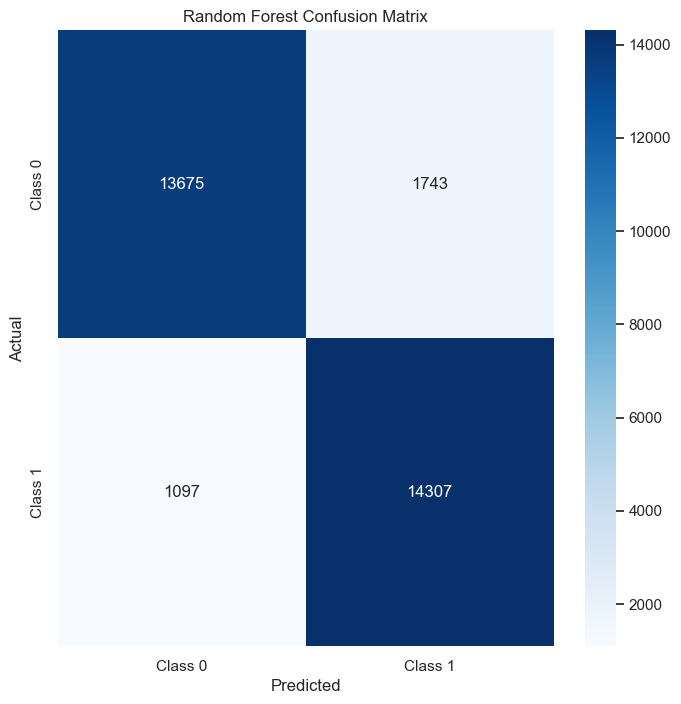

In [228]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_scores = rf.score(X_val, y_val)

evaluation_model(rf, "Random Forest")


 KNN Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.90     15418
           1       0.88      0.94      0.91     15404

    accuracy                           0.91     30822
   macro avg       0.91      0.91      0.91     30822
weighted avg       0.91      0.91      0.91     30822


 KNN Confusion Matrix:
[[13496  1922]
 [  932 14472]]


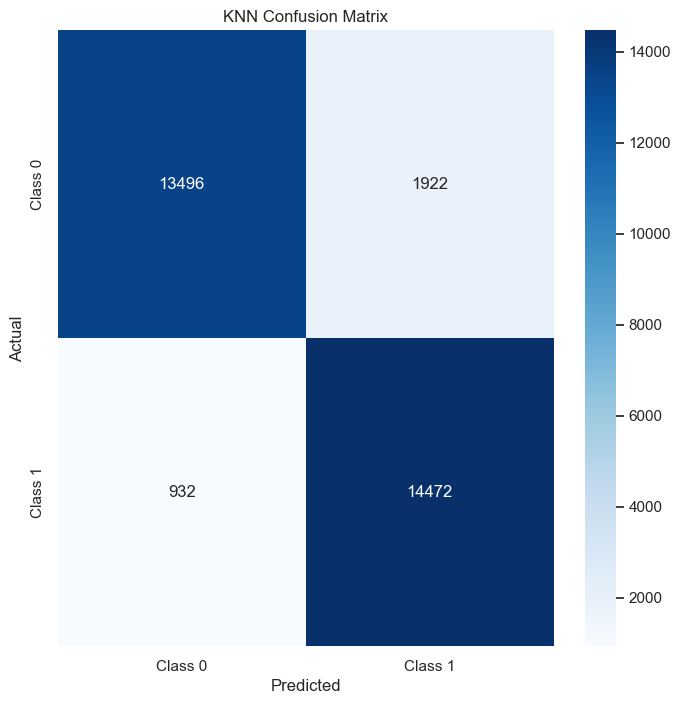

In [229]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_scores = knn.score(X_val, y_val)

evaluation_model(knn, "KNN")

## Neural Network Trainings

In [230]:
x_train = pd.DataFrame(X_train)
x_train = x_train.values
sample = x_train.shape[0]
features = x_train.shape[1]
#Train: convert 2D to 3D for input RNN
x_train = np.reshape(x_train,(sample,features,1))
#Test: convert 2D to 3D for input RNN
x_test=pd.DataFrame(X_val)
x_test = x_test.values
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], 1))

In [231]:
lstm_model = keras.Sequential([
        keras.layers.LSTM(80, input_shape = (features,x_train.shape[2]),
                          activation='tanh', recurrent_activation='hard_sigmoid'),
        keras.layers.Dense(1,activation="tanh")
    ])

lstm_model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

#Training the model
lstm_model.fit(x_train, y_train, epochs=10, batch_size= 32) 
lstm_model.summary()

# Final evaluation of the model
scores = lstm_model.evaluate(x_test, y_val, verbose=0)
print("/n")
print("LSTM Accuracy: %.2f%%" % (scores[1] * 100))

Epoch 1/10
3853/3853 [==============================] - 72s 18ms/step - loss: 0.0981 - accuracy: 0.8724
Epoch 2/10
3853/3853 [==============================] - 63s 16ms/step - loss: 0.0695 - accuracy: 0.9070
Epoch 3/10
3853/3853 [==============================] - 60s 15ms/step - loss: 0.0681 - accuracy: 0.9085
Epoch 4/10
3853/3853 [==============================] - 62s 16ms/step - loss: 0.0678 - accuracy: 0.9087
Epoch 5/10
3853/3853 [==============================] - 65s 17ms/step - loss: 0.0678 - accuracy: 0.9089
Epoch 6/10
3853/3853 [==============================] - 65s 17ms/step - loss: 0.0675 - accuracy: 0.9090
Epoch 7/10
3853/3853 [==============================] - 70s 18ms/step - loss: 0.0677 - accuracy: 0.9088
Epoch 8/10
3853/3853 [==============================] - 76s 20ms/step - loss: 0.0677 - accuracy: 0.9088
Epoch 9/10
3853/3853 [==============================] - 69s 18ms/step - loss: 0.0674 - accuracy: 0.9090
Epoch 10/10
3853/3853 [==============================] - 79s 21m

# GRU Model

In [232]:
gru_model = keras.Sequential([
        keras.layers.GRU(80, input_shape=(features, x_train.shape[2]),
                         activation='tanh', recurrent_activation='hard_sigmoid'),
        keras.layers.Dense(1, activation="tanh")
    ])

gru_model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

# Training the model
gru_model.fit(x_train, y_train, epochs=10, batch_size=32)
gru_model.summary()

# Final evaluation of the model
gru_scores = gru_model.evaluate(x_test, y_val, verbose=0)
print("\n")
print("GRU Accuracy: %.2f%%" % (gru_scores[1] * 100))

Epoch 1/10
3853/3853 [==============================] - 63s 16ms/step - loss: 0.1057 - accuracy: 0.8553
Epoch 2/10
3853/3853 [==============================] - 67s 17ms/step - loss: 0.0708 - accuracy: 0.9069
Epoch 3/10
3853/3853 [==============================] - 52s 14ms/step - loss: 0.0714 - accuracy: 0.9058
Epoch 4/10
3853/3853 [==============================] - 49s 13ms/step - loss: 0.0702 - accuracy: 0.9067
Epoch 5/10
3853/3853 [==============================] - 50s 13ms/step - loss: 0.0692 - accuracy: 0.9082
Epoch 6/10
3853/3853 [==============================] - 49s 13ms/step - loss: 0.0688 - accuracy: 0.9084
Epoch 7/10
3853/3853 [==============================] - 49s 13ms/step - loss: 0.0687 - accuracy: 0.9086
Epoch 8/10
3853/3853 [==============================] - 49s 13ms/step - loss: 0.0692 - accuracy: 0.9082
Epoch 9/10
3853/3853 [==============================] - 50s 13ms/step - loss: 0.0685 - accuracy: 0.9085
Epoch 10/10
3853/3853 [==============================] - 49s 13m

# Evaluation Module

In [233]:
def evaluation_model_neural(model, label):
    # Predictions on the test set
    y_pred = model.predict(x_test)

    # Convert predictions to binary values (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Classification Report
    class_report = classification_report(y_val, y_pred_binary)
    print(f"\n {label} Classification Report:")
    print(class_report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred_binary)
    print(f"\n {label} Confusion Matrix:")
    print(conf_matrix)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f'{label} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

964/964 [==============================] - 4s 3ms/step

 LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     15418
           1       0.88      0.94      0.91     15404

    accuracy                           0.91     30822
   macro avg       0.91      0.91      0.91     30822
weighted avg       0.91      0.91      0.91     30822


 LSTM Confusion Matrix:
[[13443  1975]
 [  916 14488]]


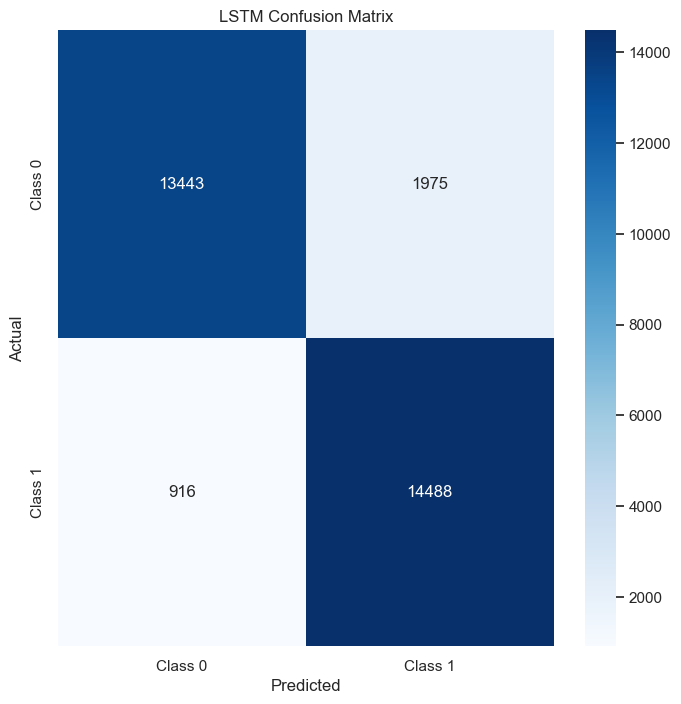

In [234]:
evaluation_model_neural(lstm_model, "LSTM")

964/964 [==============================] - 3s 3ms/step

 GRU Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     15418
           1       0.89      0.93      0.91     15404

    accuracy                           0.91     30822
   macro avg       0.91      0.91      0.91     30822
weighted avg       0.91      0.91      0.91     30822


 GRU Confusion Matrix:
[[13640  1778]
 [ 1105 14299]]


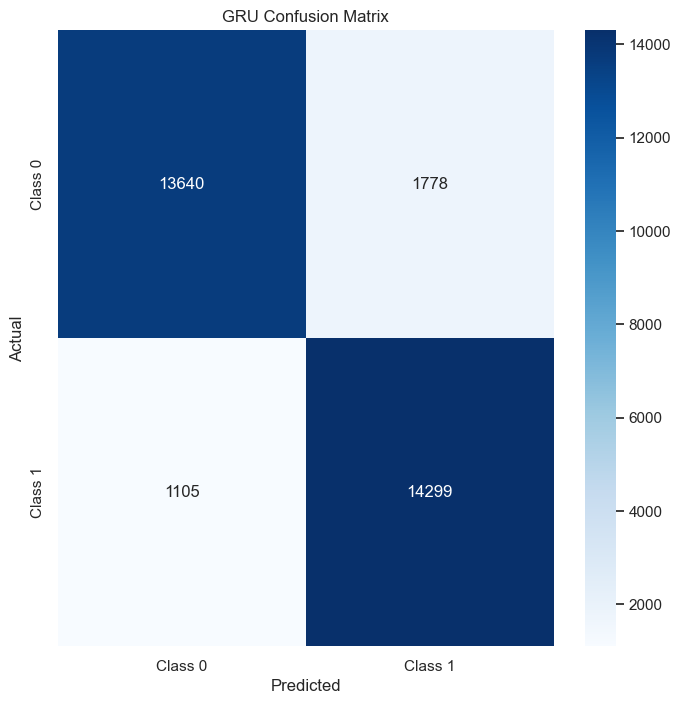

In [235]:
evaluation_model_neural(gru_model, "GRU")